In [14]:
import h5py
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs
import seaborn as sns
import pandas as pd
import pickle

## True FP vs training set

In [15]:
mols_file = "../../data/paired_spectra/canopus_train_public/labels.tsv"
split_file = "../../data/paired_spectra/canopus_train_public/splits/canopus_hplus_100_0.csv"

all_mols = pd.read_csv(mols_file, sep="\t")
split = pd.read_csv(split_file)

train = split[split["Fold_100_0"] == "train"]
train_mols = all_mols[all_mols["spec"].isin(train["name"])]

assert len(train) == len(train_mols)

In [16]:
def smiles_to_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=4096)
    return fp

In [17]:
train_mols["fp"] = train_mols["smiles"].apply(smiles_to_fp)

/var/folders/n5/t_ds6vws3ns1lyk9130hfx180000gn/T/ipykernel_68983/368352718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_mols["fp"] = train_mols["smiles"].apply(smiles_to_fp)


In [18]:
# casmi_file = "../../data/paired_spectra/casmi2022/labels_true.tsv"
# casmi_mols = pd.read_csv(casmi_file, sep="\t")
casmi_file = "../../data/paired_spectra/casmi2022/casmi_classyfire_results.pkl"
casmi_mols = pd.read_pickle(casmi_file)
casmi_mols["fp"] = casmi_mols["smiles"].apply(smiles_to_fp)

In [19]:
# Find the most similar molecule in the training set for each CASMI molecule by Tanimoto similarity
casmi_mols["train_true_most_similar"] = None
casmi_mols["train_true_similarity"] = None
for i, row in casmi_mols.iterrows():
    fp = row["fp"]
    similarities = train_mols["fp"].apply(
        lambda x: DataStructs.TanimotoSimilarity(fp, x)
    )
    max_sim = similarities.max()
    max_idx = similarities.idxmax()
    casmi_mols.at[i, "train_true_most_similar"] = train_mols.loc[
        max_idx, "smiles"
    ]
    casmi_mols.at[i, "train_true_similarity"] = max_sim

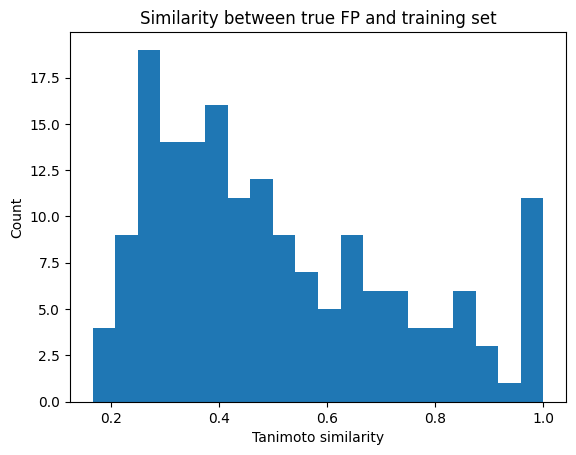

In [20]:
# Plot the distribution of similarities
import matplotlib.pyplot as plt

plt.hist(casmi_mols["train_true_similarity"], bins=20)
plt.xlabel("Tanimoto similarity")
plt.ylabel("Count")
plt.title("Similarity between true FP and training set")
plt.show()

## predicted FP vs training set

In [21]:
pred_file = "../../results/retrained_models/contrast_model_aug/retrieval_casmi2022/retrieval_canopus_hplus_100_0.p"
hdf_file = "../../data/paired_spectra/casmi2022/retrieval_hdf/intpubchem_with_morgan4096_retrieval_db.hdf5"

with open(pred_file, "rb") as f:
    preds = pickle.load(f)

pred_inds = [inds[0] for inds in preds["ranking"]]
names = preds["names"].tolist()
print(names)
print(pred_inds)

db = h5py.File(hdf_file, "r")
pred_fp = [db["fingerprints"][i] for i in pred_inds]
pred_fp_bs = ["".join(fp.astype(str)) for fp in pred_fp]
pred_fp = [
    DataStructs.cDataStructs.CreateFromBitString(fp) for fp in pred_fp_bs
]

print(casmi_mols["name"].tolist())

# Add to casmi_mols dataframe based on names
casmi_mols["pred_fp"] = None
for i, name in enumerate(names):
    casmi_mols.at[
        casmi_mols.index[casmi_mols["name"] == name][0], "pred_fp"
    ] = pred_fp[i]

# Find the most similar molecule in the training set for each CASMI molecule by Tanimoto similarity
casmi_mols["pred_train_most_similar"] = None
casmi_mols["pred_train_similarity"] = None
for i, row in casmi_mols.iterrows():
    fp = row["pred_fp"]
    similarities = train_mols["fp"].apply(
        lambda x: DataStructs.TanimotoSimilarity(fp, x)
    )
    max_sim = similarities.max()
    max_idx = similarities.idxmax()
    casmi_mols.at[i, "pred_train_most_similar"] = train_mols.loc[
        max_idx, "smiles"
    ]
    casmi_mols.at[i, "pred_train_similarity"] = max_sim

['casmi2022_10', 'casmi2022_491', 'casmi2022_41', 'casmi2022_456', 'casmi2022_407', 'casmi2022_209', 'casmi2022_318', 'casmi2022_248', 'casmi2022_308', 'casmi2022_219', 'casmi2022_359', 'casmi2022_34', 'casmi2022_417', 'casmi2022_423', 'casmi2022_466', 'casmi2022_268', 'casmi2022_278', 'casmi2022_369', 'casmi2022_229', 'casmi2022_55', 'casmi2022_476', 'casmi2022_442', 'casmi2022_92', 'casmi2022_453', 'casmi2022_21', 'casmi2022_467', 'casmi2022_15', 'casmi2022_238', 'casmi2022_269', 'casmi2022_329', 'casmi2022_339', 'casmi2022_368', 'casmi2022_228', 'casmi2022_54', 'casmi2022_477', 'casmi2022_443', 'casmi2022_463', 'casmi2022_490', 'casmi2022_11', 'casmi2022_457', 'casmi2022_208', 'casmi2022_319', 'casmi2022_309', 'casmi2022_189', 'casmi2022_358', 'casmi2022_35', 'casmi2022_64', 'casmi2022_480', 'casmi2022_422', 'casmi2022_130', 'casmi2022_237', 'casmi2022_377', 'casmi2022_384', 'casmi2022_295', 'casmi2022_104', 'casmi2022_439', 'casmi2022_468', 'casmi2022_478', 'casmi2022_285', 'casmi2

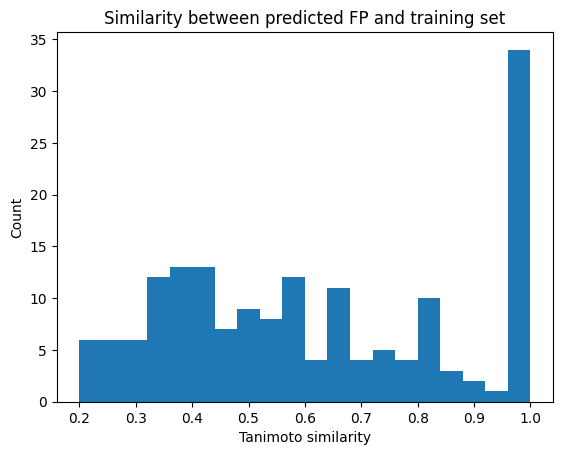

In [22]:
# Plot the distribution of similarities
plt.hist(casmi_mols["pred_train_similarity"], bins=20)
plt.xlabel("Tanimoto similarity")
plt.ylabel("Count")
plt.title("Similarity between predicted FP and training set")
plt.show()

## pred FP vs true FP

In [23]:
# Find the most similar molecule in the CASMI set for each CASMI molecule by Tanimoto similarity
casmi_mols["pred_true_most_similar"] = None
casmi_mols["pred_true_similarity"] = None
for i, row in casmi_mols.iterrows():
    fp = row["pred_fp"]
    similarities = casmi_mols["fp"].apply(
        lambda x: DataStructs.TanimotoSimilarity(fp, x)
    )
    max_sim = similarities.max()
    max_idx = similarities.idxmax()
    casmi_mols.at[i, "pred_true_most_similar"] = casmi_mols.loc[
        max_idx, "smiles"
    ]
    casmi_mols.at[i, "pred_true_similarity"] = max_sim

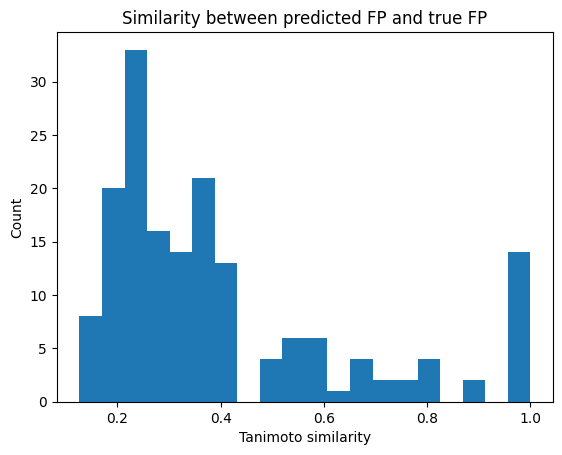

In [24]:
# Plot the distribution of similarities
plt.hist(casmi_mols["pred_true_similarity"], bins=20)
plt.xlabel("Tanimoto similarity")
plt.ylabel("Count")
plt.title("Similarity between predicted FP and true FP")
plt.show()

In [25]:
casmi_mols.to_pickle("../../results/casmi_fp_analysis/casmi_mols_df.pkl")
casmi_mols.to_csv("../../results/casmi_fp_analysis/casmi_mols.tsv", sep="\t")

## True-train vs pred-train

In [26]:
plt.style.use(["seaborn-white", "seaborn-paper"])
plt.rc("font", family="sans serif")
# sns.set_palette(['#9e0059', '#6da7de', '#ee266d', '#dee000', '#eb861e'])
sns.set_context("paper", font_scale=1.3)

/var/folders/n5/t_ds6vws3ns1lyk9130hfx180000gn/T/ipykernel_68983/2332962258.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn-white", "seaborn-paper"])
/var/folders/n5/t_ds6vws3ns1lyk9130hfx180000gn/T/ipykernel_68983/2332962258.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(["seaborn-white", "seaborn-paper"])


below diagonal: 48
above diagoneal: 105
on diagonal: 17


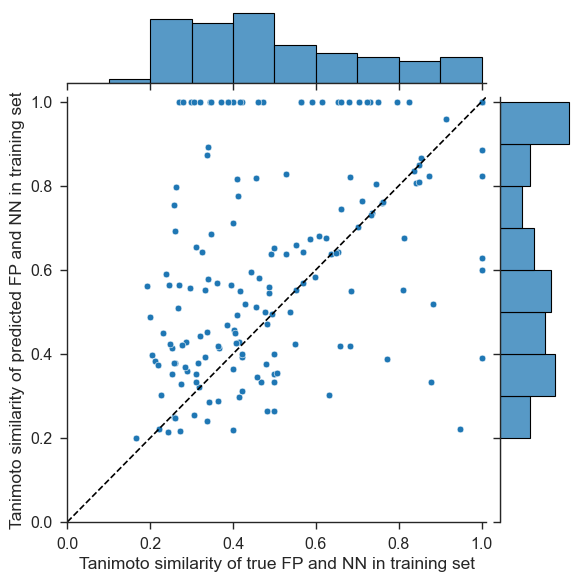

In [27]:
# count number of molecules where pred similarity is higher than pred-train similarity
print(
    f"below diagonal: {sum(casmi_mols['train_true_similarity'] > casmi_mols['pred_train_similarity'])}"
)
print(
    f"above diagoneal: {sum(casmi_mols['train_true_similarity'] < casmi_mols['pred_train_similarity'])}"
)
print(
    f"on diagonal: {sum(casmi_mols['train_true_similarity'] == casmi_mols['pred_train_similarity'])}"
)

# Scatterplot tanimoto similarities true-train vs pred-train
sns.jointplot(
    data=casmi_mols,
    x="train_true_similarity",
    y="pred_train_similarity",
    kind="scatter",
    marginal_kws=dict(bins=np.arange(0, 1.01, 0.1)),
)
plt.plot([0, 1.01], [0, 1.01], "k--")
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel("Tanimoto similarity of true FP and NN in training set")
plt.ylabel("Tanimoto similarity of predicted FP and NN in training set")
plt.show()

## Pred-true vs pred-train

below diagonal: 17
above diagoneal: 146
on diagonal: 7


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


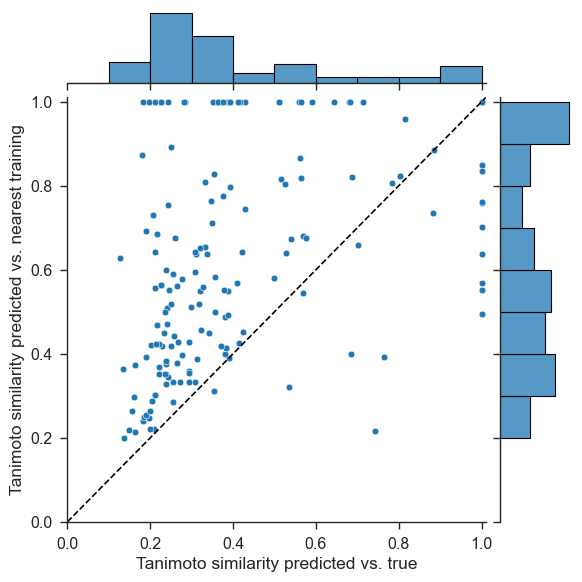

In [28]:
# count number of molecules where pred similarity is higher than pred-train similarity
print(
    f"below diagonal: {sum(casmi_mols['pred_true_similarity'] > casmi_mols['pred_train_similarity'])}"
)
print(
    f"above diagoneal: {sum(casmi_mols['pred_true_similarity'] < casmi_mols['pred_train_similarity'])}"
)
print(
    f"on diagonal: {sum(casmi_mols['pred_true_similarity'] == casmi_mols['pred_train_similarity'])}"
)
# Scatterplot tanimoto similarities true-train vs pred-train
sns.jointplot(
    data=casmi_mols,
    x="pred_true_similarity",
    y="pred_train_similarity",
    kind="scatter",
    # hue="Superclass",
    marginal_kws=dict(bins=np.arange(0, 1.01, 0.1)),
)
plt.plot([0, 1.01], [0, 1.01], "k--")
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel("Tanimoto similarity predicted vs. true")
plt.ylabel("Tanimoto similarity predicted vs. nearest training")
plt.legend(bbox_to_anchor=(1.2, 1.05))
plt.show()

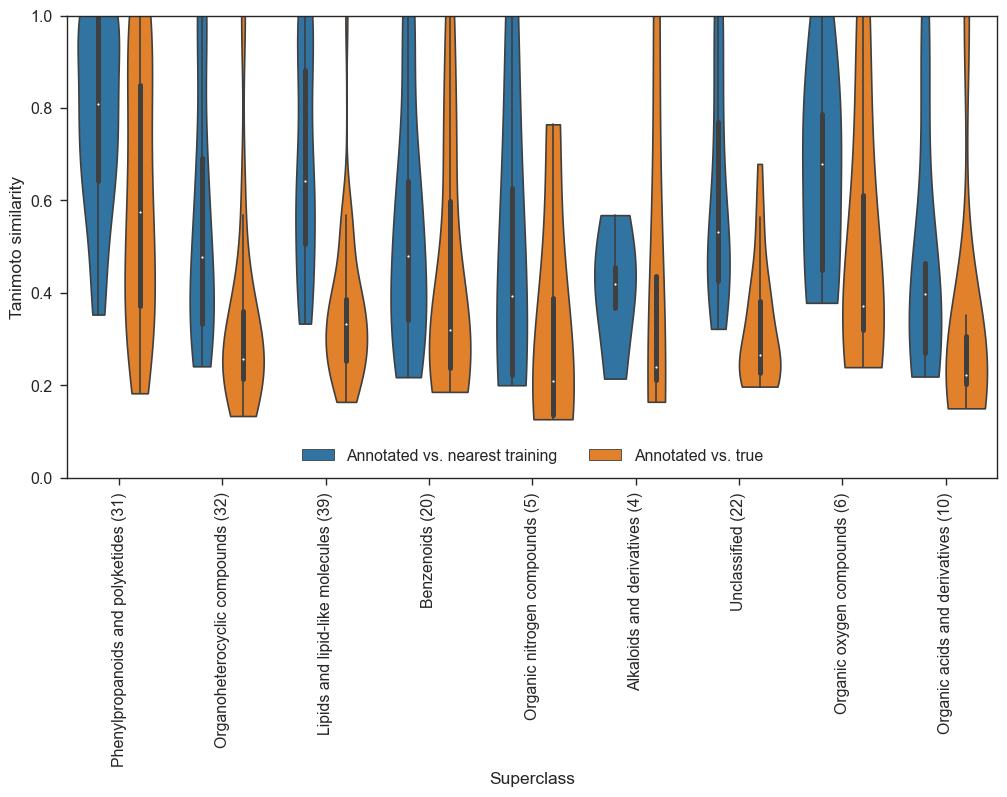

In [29]:
# plot violin plot of similarities per superclass

superclass_sim = casmi_mols.melt(
    id_vars="Superclass",
    value_vars=["pred_train_similarity", "pred_true_similarity"],
    var_name="similarity_type",
    value_name="similarity",
)

# drop superclass with only 1 molecule
superclass_sim = superclass_sim.groupby("Superclass").filter(
    # len(x) > 2 because we have 2 similarity types
    lambda x: len(x)
    > 2
)

superclass_sim["similarity"] = superclass_sim["similarity"].astype(float)
fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
sns.violinplot(
    data=superclass_sim,
    x="Superclass",
    y="similarity",
    hue="similarity_type",
    palette="tab10",
    split=False,
    cut=0,
    ax=ax,
)
# add number of molecules in each superclass to tick labels between brackets
superclass_counts = casmi_mols.groupby("Superclass").size()
superclass_counts = superclass_counts[superclass_sim["Superclass"].unique()]
superclass_counts = superclass_counts.reset_index()
superclass_counts["Superclass"] = (
    superclass_counts["Superclass"]
    + " ("
    + superclass_counts[0].astype(str)
    + ")"
)
plt.xticks(
    ticks=range(len(superclass_counts)), labels=superclass_counts["Superclass"]
)
plt.xticks(rotation=90)
plt.ylabel("Tanimoto similarity")
plt.xlabel("Superclass")
plt.ylim([0, 1])
h, l = ax.get_legend_handles_labels()
ax.legend(
    h[:2],
    ["Annotated vs. nearest training", "Annotated vs. true"],
    loc="lower center",
    ncol=2,
)
# plt.show()

save_name = "../../results/casmi_fp_analysis/casmi_fp_analysis_violin.pdf"
plt.savefig(
    save_name, format="pdf", bbox_inches="tight", dpi=600, transparent=True
)

In [30]:
superclass_sim

,Superclass,similarity_type,similarity
0,Phenylpropanoids and polyketides,pred_train_similarity,0.735632
1,Organoheterocyclic compounds,pred_train_similarity,1.000000
2,Organoheterocyclic compounds,pred_train_similarity,0.287500
3,Organoheterocyclic compounds,pred_train_similarity,0.240964
4,Lipids and lipid-like molecules,pred_train_similarity,0.866667
...,...,...,...
335,Organic nitrogen compounds,pred_true_similarity,0.126437
336,Phenylpropanoids and polyketides,pred_true_similarity,0.428571
337,Lipids and lipid-like molecules,pred_true_similarity,0.163934
338,Lipids and lipid-like molecules,pred_true_similarity,0.371795
